In [5]:
# Training a small convnet from scratch to classify weather condition (i.e. cloudy, partly_cloudy, clear, haze)
# See: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense


In [9]:
data_dir = 'D:/Downloads/amazon/'
num_samples_per_epoch = 1000
num_epoch = 20
train_dir = data_dir + 'preprocess/train-jpg'
validation_dir = data_dir + 'preprocess/validation-jpg'
batch_size = 32
num_validations_per_epoch = 600
# all images will be resized to 128x128, which reduces number of pixels by 4x.
rescaled_dim = 128

In [3]:

model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(3, rescaled_dim, rescaled_dim)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))  # we have 4 classes so we need 4 neurons
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',  # was binary_crossentropy
              optimizer='adagrad',
              metrics=['accuracy'])


In [4]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of train_dir, and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(rescaled_dim, rescaled_dim),  
        batch_size=batch_size,
        class_mode='categorical')  # TODO 

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode='categorical') # TODO

Found 32383 images belonging to 4 classes.
Found 8096 images belonging to 4 classes.


In [13]:
# steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. 
# It should typically be equal to the number of unique samples of your dataset divided by the batch size.

history = model.fit_generator(
        train_generator,
        samples_per_epoch=num_samples_per_epoch, #  not using all training samples at every epoch.
        nb_epoch=num_epoch,
        validation_data=validation_generator,
        nb_val_samples=num_validations_per_epoch)
model.save(data_dir + 'models/model_first_try.h5')  # always save your model and weights after training or during training
print('done')

Epoch 1/20
1024/1000 [==============================] - 38s - loss: 1.1424 - acc: 0.6670 - val_loss: 0.9059 - val_acc: 0.7056

['acc', 'loss', 'val_acc', 'val_loss']


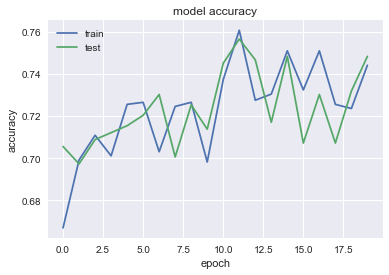

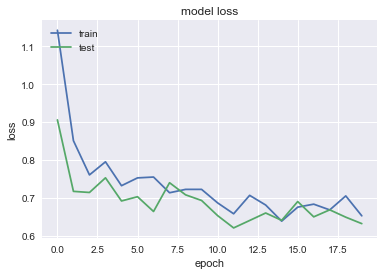

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [3]:
from keras.models import load_model
model = load_model(data_dir + 'models/model_first_try.h5')

In [29]:
number_of_predictions = 59 # must not be greater than the number of test images in the directory
# predict label for a set of handpicked test images
testset_datagen = ImageDataGenerator(rescale=1./255)

testset_dir = data_dir + 'preprocess/test'

testset_generator = testset_datagen.flow_from_directory(
        testset_dir,
        target_size=(rescaled_dim, rescaled_dim),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

#scoreSeg = model.evaluate_generator(testset_generator, 300)
#print("Accuracy = ",scoreSeg[1])
predict = model.predict_generator(testset_generator, number_of_predictions)
print(predict)


Found 59 images belonging to 1 classes.
[[  2.62704998e-01   5.41107178e-01   4.94378835e-01   4.19029683e-01]
 [  6.36368275e-01   2.12678105e-01   4.02206212e-01   4.78921652e-01]
 [  9.96494710e-01   4.57027898e-04   1.42299582e-03   1.88633218e-01]
 [  5.34468770e-01   3.03059191e-01   4.86773014e-01   4.69272077e-01]
 [  9.90411341e-01   2.21424177e-03   7.36370962e-03   2.10119769e-01]
 [  3.97415310e-01   3.90561223e-01   5.06057262e-01   4.60939735e-01]
 [  1.26606643e-01   6.62928164e-01   4.27892745e-01   3.89687866e-01]
 [  9.88551736e-01   3.40252533e-03   1.21554416e-02   2.05464631e-01]
 [  3.65193516e-01   2.89573580e-01   3.54949981e-01   4.89542425e-01]
 [  1.79235101e-01   5.95912993e-01   4.24768031e-01   4.03528005e-01]
 [  9.85459983e-01   5.53725939e-03   2.00326256e-02   2.02540174e-01]
 [  9.89219844e-01   2.73772678e-03   9.20808688e-03   2.16354117e-01]
 [  5.51812410e-01   1.31262302e-01   1.91914484e-01   5.26875734e-01]
 [  8.01775455e-02   7.85563409e-01  

In [11]:
print testset_generator.filenames

['test-001-jpg\\train_1022.jpg', 'test-001-jpg\\train_103.jpg', 'test-001-jpg\\train_11.jpg', 'test-001-jpg\\train_1147.jpg', 'test-001-jpg\\train_1232.jpg', 'test-001-jpg\\train_1384.jpg', 'test-001-jpg\\train_143.jpg', 'test-001-jpg\\train_1483.jpg', 'test-001-jpg\\train_1492.jpg', 'test-001-jpg\\train_1520.jpg', 'test-001-jpg\\train_1611.jpg', 'test-001-jpg\\train_162.jpg', 'test-001-jpg\\train_1663.jpg', 'test-001-jpg\\train_1711.jpg', 'test-001-jpg\\train_1738.jpg', 'test-001-jpg\\train_1786.jpg', 'test-001-jpg\\train_18.jpg', 'test-001-jpg\\train_1828.jpg', 'test-001-jpg\\train_194.jpg', 'test-001-jpg\\train_203.jpg', 'test-001-jpg\\train_2058.jpg', 'test-001-jpg\\train_2138.jpg', 'test-001-jpg\\train_215.jpg', 'test-001-jpg\\train_220.jpg', 'test-001-jpg\\train_2267.jpg', 'test-001-jpg\\train_23.jpg', 'test-001-jpg\\train_2504.jpg', 'test-001-jpg\\train_2516.jpg', 'test-001-jpg\\train_259.jpg', 'test-001-jpg\\train_26.jpg', 'test-001-jpg\\train_2632.jpg', 'test-001-jpg\\train_28

In [30]:
predictions_index = np.argmax(predict, axis=1)
print(predictions_index)

[1 0 0 0 0 2 1 0 3 1 0 0 0 1 1 1 0 1 0 1 0 0 0 3 1 0 1 1 0 1 1 0 1 0 0 1 0
 0 1 0 0 0 1 0 1 0 0 1 0 1 3 0 0 0 0 2 0 1 1]


20


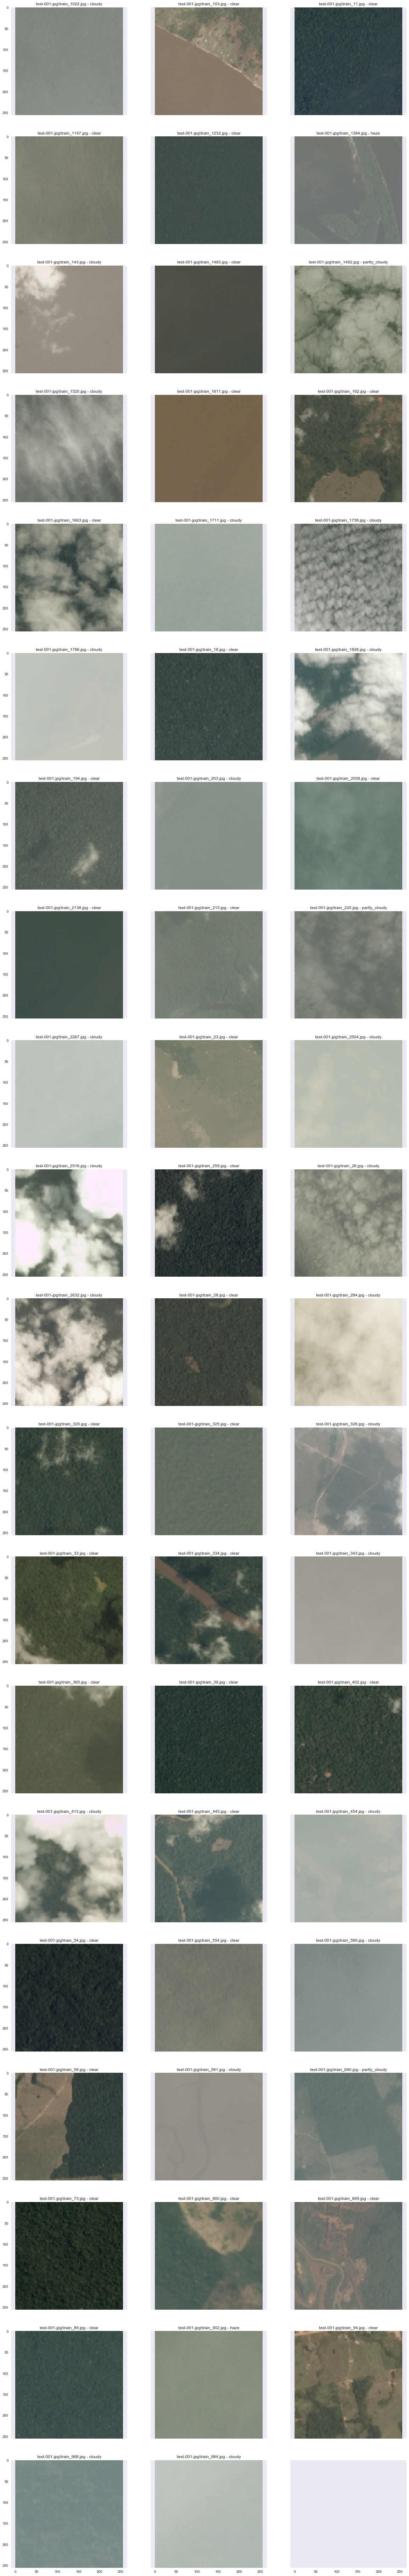

In [42]:
def int_to_label(index):
    labels = ['clear', 'cloudy', 'haze', 'partly_cloudy']
    return labels[index]

new_style = {'grid': False}
plt.rc('axes', **new_style)

num_cols = 3;
num_rows = int(np.ceil(number_of_predictions / num_cols)) + 1
#print(num_rows)

_, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(20,20*num_rows/num_cols))
i = 0
while i < predictions_index.size:
    file_path = testset_generator.filenames[i]
    #print(file_path)
    #print(testset_dir + '/' + file_path)
    img = cv2.imread(testset_dir + '/' + file_path)
    ax[i // num_cols, i % num_cols].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    label = int_to_label(predictions_index[i])
    ax[i // num_cols, i % num_cols].set_title('{} - {}'.format(file_path, label))
    i += 1
    
plt.show()